In [7]:
%load_ext autoreload
%autoreload 2
# %matplotlib qt5
%matplotlib inline

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
from plot_helpers import *
import numpy as np
import os
import math
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)


############## FIGURES ##############
# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

# plt.style.use('ggplot')
plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [2.12, 1.6]


default  = np.array([3.3,   2.5])
double   = np.array([6.6,   5])
tlwidth  = np.array([1.58, 2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
fl22  = np.array([4.75,  2])
flhh  = np.array([4.75,  1.25])

figfolder = 'plots'

############### Experiment selection ###################

EXP_list     = [exp_folder.split('experiment_')[-1][:-1] for exp_folder in sorted(glob.glob('%s/*/' % datadir))]
CFG_dict = {exp: [cfg_folder.split('/')[-2] for cfg_folder in sorted(glob.glob('%s/%s/*/' % (datadir,'experiment_'+exp)))] for exp in EXP_list}
REP_dict = {exp+'/'+cfg: [rep_folder.split('/')[-2] for rep_folder in sorted(glob.glob('%s/%s/%s/*/' % (datadir,'experiment_'+exp, cfg)))] for exp in EXP_list for cfg in CFG_dict[exp]} 

EXP_drop = widgets.Dropdown(
    options=EXP_list,
    value=EXP_list[-1],
    description='Exp:',
    disabled=False,
)

EXP_multiple = widgets.SelectMultiple(
    options=EXP_list,
    value=[EXP_list[-1]],
    description='Exp:',
    disabled=False,
)

CFG_drop = widgets.Dropdown(description='Cfg:',disabled=False)
REP_drop = widgets.Dropdown(description='Rep:',disabled=False)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        CFG_drop.options = CFG_dict[EXP_drop.value]
        REP_drop.options = REP_dict[EXP_drop.value+'/'+CFG_drop.value]
        
EXP_drop.observe(on_change)
CFG_drop.observe(on_change)

display(EXP_drop, CFG_drop, REP_drop)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dropdown(description='Exp:', index=8, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '111_epsilon',…

Dropdown(description='Cfg:', options=(), value=None)

Dropdown(description='Rep:', options=(), value=None)

## Time elapsed between blocks

SelectMultiple(description='Experiment:', index=(1,), options=('100_epsilon_1', '110_epsilon', '130_staking', …

Experiment datasets: 110_epsilon
New plot directory is created!


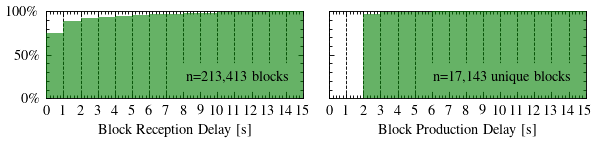

In [23]:
display(EXP_multiple)
EXP = EXP_multiple.value
# display(EXP_drop)
# EXP = EXP_drop.value
print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df(EXP, 'block')
# df = df.get_param(df,'generic_params','block_period')
XMAX = 15

###############################################################
# Process the dataframe  
bins = range(0, XMAX+1, 1)

# Create figure
fig, ax = plt.subplots(1,2, sharey=True, figsize=flhh)

# Create plot
hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax[0].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder= 3)
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[0].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_ylim(ymin=0, ymax = 1)
ax[0].set_xticks(bins)
ax[0].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[0].set_xlabel('Block Reception Delay  [s]')

###############################################################
# Process the dataframe  
df = df.drop_duplicates('HASH')
df = trim_chain(df, 10).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax[1].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder=3)
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[1].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[1].set_ylim(ymin=0, ymax = 1)
ax[1].set_xticks(bins)
ax[1].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[1].set_xlabel('Block Production Delay  [s]')

# Save plot
fig.tight_layout()
# plt.savefig("plots/multi/time_elapsed_both.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between block production to reception

In [60]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')
df = df.get_param(df,'generic_params','block_period')

# Process the data  
bins = range(0, 30, df['block_period'].min())
# XX = df.groupby('HASH')['TELAPSED'].agg('max')
XX = df['TELAPSED']

# Create plot
ax = plt.axes()
hist, bins = np.histogram(XX, bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 
ax.set_title('Time elapsed between block \n production and reception (%s blocks)' % len(XX))

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks received within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Travel Time  [s]')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/time_elapsed_recept.png", bbox_inches='tight', dpi=600)
plt.show()

Dropdown(description='Experiment:', index=4, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '111_ep…

NameError: name 'generic_params' is not defined

changed to 110_epsilon_2
changed to 100_epsilon_1
changed to 111_epsilon


## Time elapsed between consecutive blocks

Dropdown(description='Experiment:', index=17, options=('backup_test116_patchy_single_', 'test101', 'test102', …

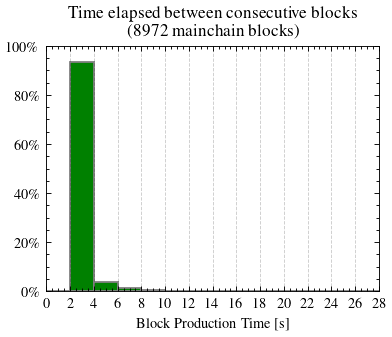

In [6]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')

# Process the dataframe  
df = df.get_param(df,'generic_params','block_period')
bins = range(0, 30, df['block_period'].min())

df = df.drop_duplicates('HASH')
df = trim_chain(df, 8).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.set_title('Time elapsed between consecutive blocks \n (%s mainchain blocks)' % len(df))
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks produced within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Production Time  [s]')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/time_elapsed_prod.png", dpi=600)
plt.show()

## Check how many blocks were produced

In [9]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')

# Process the dataframe  
df = df.get_param(df,'generic','block_period')
df = df.drop_duplicates('HASH')
YY = 'BLOCK'

display(df.groupby(['EXP', 'CFG', 'REP'], as_index=False).agg({YY:'max'}))


Dropdown(description='Experiment:', index=4, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '111_ep…

,EXP,CFG,REP,BLOCK
0,112_epsilon,egreedy_0,001,424
1,112_epsilon,egreedy_0,002,421
2,112_epsilon,egreedy_0,003,435
3,112_epsilon,egreedy_0,004,426
4,112_epsilon,egreedy_0,005,431
5,112_epsilon,egreedy_10,001,426
6,112_epsilon,egreedy_10,002,427
7,112_epsilon,egreedy_10,003,430
8,112_epsilon,egreedy_10,004,441
9,112_epsilon,egreedy_10,005,433


## Local memory occupied by chaindata

Dropdown(description='Experiment:', index=26, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

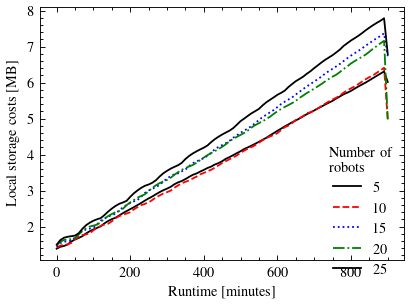

In [3]:
# display(EXP_multiple)
# EXP = EXP_multiple.value
display(EXP_drop)
EXP = EXP_drop.value
# print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df2(EXP, 'extra', exclude_patterns = ['greedy'])
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = df.query('Robots <= 25')

df['TEMP'] = df['TIME']/10
df['TIME_S'] = df['TEMP'].round().astype(int) * 10

# df = df.query('REP == "001"')
# display(df)
# Process the dataframe  
# df = df.groupby(['Robots']).apply(lambda x: LinearRegression(x, 'TIME', 'MB'))

# display(df[['Robots','MB']])
# Create plot


ax = plt.axes()
# display(df)
# df = df[['Robots','TIME_M','MB']]
# display(df.groupby(['Robots', 'TIME_M'], as_index=False).mean().set_index('TIME_M')['MB'])

df.groupby(['Robots', 'TIME_S'], as_index=False).mean().set_index('TIME_S')[['Robots','MB']].groupby('Robots')['MB'].plot(ax=ax)

# df.groupby('Robots').boxplot(column='MB', by='TIME_MR', figsize=double)
# sns.boxplot(x=df['TIME_MR'], y=df['MB'], hue=df['Robots'], showfliers = False)

# display(df)
# s = df.pivot('TIME_M', 'ID', 'MB').mean(axis=1).resample('0.15S').mean()

# display(df)
# df['MB_mov_avg'] = df.set_index(['TIME_M']).groupby('REP')['MB'].transform(lambda x: x.rolling(10, 1).mean())
# df['MB_mov_avg'] = df.set_index(['TIME_M']).groupby('REP').rolling(10)['MB'].mean().reset_index(drop=True)
# display(df)
# s.plot(ax = ax, figsize = double)
# display(df)
# df.set_index(['TIME']).groupby(['EXP', 'REP', 'ID'])['MB'].plot(ax = ax, color='gray', label='_nolegend_', linewidth=0.2, alpha = 0.1, zorder=0)

# Edit plot
# xmax = math.ceil(df['TIME'].max()/60)
# xticks = range(0,xmax,1)
# ax.set_xlim(xmin=0,xmax = xmax)
# ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('Local storage costs [MB]')
ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
# plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()

Dropdown(description='Experiment:', index=26, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

       ID     TIME       MB  REP              EXP             CFG  \
11576   1    0.543  1.43059  014  test120_scaling  10_blockchain2   
11577   1   10.606  1.46004  014  test120_scaling  10_blockchain2   
11578   1   20.649  1.46004  014  test120_scaling  10_blockchain2   
11579   1   30.694  1.46004  014  test120_scaling  10_blockchain2   
11580   1   40.791  1.53333  014  test120_scaling  10_blockchain2   
...    ..      ...      ...  ...              ...             ...   
51209   9  859.546  4.87961  010  test120_scaling  20_blockchain2   
51210   9  869.683  4.93754  010  test120_scaling  20_blockchain2   
51211   9  879.926  5.01139  010  test120_scaling  20_blockchain2   
51212   9  890.042  5.11349  010  test120_scaling  20_blockchain2   
51213   9  900.225  5.20095  010  test120_scaling  20_blockchain2   

        CONTROLLER  Robots     TIME_M     COEFS      LREG  
11576  blockchain2      10   0.009050  0.285587  0.002585  
11577  blockchain2      10   0.176767  0.285587  0.

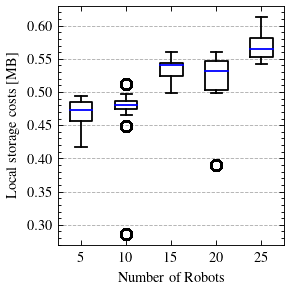

In [4]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df2(EXP, 'extra')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df['TIME_M'] = df['TIME']/60
df = df.query('Robots <= 25')

# Plot options
XX = 'Robots'
YY = 'MB'
yl = 'Local storage costs [MB]'
fs = hlwidth

# Process the data
df = df.groupby(['EXP','CFG', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
print(df.query('COEFS < 0.4'))
# df = df.groupby(['Robots', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
# ax = plt.axes()
fig,ax = plt.subplots(1,1,figsize=fs) 

bp = df.boxplot(column='COEFS', by = XX, figsize=fs, ax=ax)
# bp = df.boxplot(column=[YY], by = XX, figsize=flhh, ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel("Number of %s" % ax.get_xlabel())
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

Dropdown(description='Experiment:', index=26, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

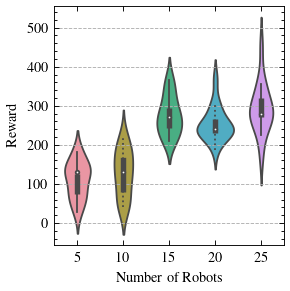

In [10]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = df.query('Robots <= 25')

# Plot options
XX = 'Robots'
YY = 'VALUE'
yl = 'Reward'
fs = hlwidth

# Process the data
# df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
df = df.groupby(['Robots', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
fig,ax = plt.subplots(1,1,figsize=fs) 
# bp = df.boxplot(column='COEFS', by = XX, ax=ax)
# bp = df.boxplot(column=[YY], by = XX, ax=ax)
bp = sns.violinplot(df[XX], df[YY])
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel("Number of %s" % ax.get_xlabel())
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/performance_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Value Collected Over Distance Traveled 

Dropdown(description='Experiment:', index=26, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

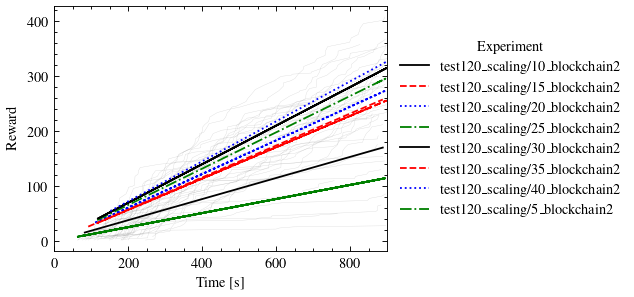

In [4]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')

# Axis data options
X_axis = 'TIME'

# Process the dataframe
df = df.groupby(['EXP']).apply(lambda x: LinearRegression0(x, X_axis, 'VALUE'))
# df = df[df['CONTROLLER'] == 'blockchain3']

# Create plot
ax = plt.axes()
df.set_index(X_axis).groupby(['EXP'])['LREG'].plot(ax=ax)
df.set_index(X_axis).groupby(['EXP','REP'])['VALUE'].plot(ax=ax, label='_nolegend_', color='gray', linestyle = '-', linewidth=0.2, alpha=0.3, zorder=0)

# Edit plot
ax.set_xlim(xmin=0,xmax = df[X_axis].max())
ax.set_ylabel('Reward')
if X_axis == 'DIST':
    ax.set_xlabel('Distance Traveled [m]')
else:
    ax.set_xlabel('Time [s]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Experiment')

## Efficiency (boxplot)

Dropdown(description='Experiment:', index=3, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '111_ep…

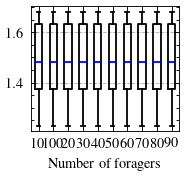

In [7]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
YY = 'SCOUT_DIST'
XX = 'CONTROLLER'
BP = 'Robots'
yl = 'Scouting efficiency'
fs = 0.66*hlwidth
# df = df.query('Recruits in [0,1]')
# df = df.query('Robots==25')

# Process the data
df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharex=True, figsize=fs)

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Number of foragers")
# for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('')   

# bp[0].set_title('No Blockchain (Individualist)')
# bp[1].set_title('Blockchain (Individualist)')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/efficiency_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()


## Total Value Collected (boxplot)

Dropdown(description='Experiment:', index=3, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '111_ep…

,ID,TIME,DIST,RECRUIT_DIST,SCOUT_DIST,red,green,blue,yellow,TOTAL,VALUE,EXP,CFG,REP,CONTROLLER,Robots
0,0,0.016,0.000000,0.000000,0.000000,0,0,0,0,0,0,111_epsilon,11_10,001,10,11
1,0,0.106,0.000000,0.000000,0.000000,0,0,0,0,0,0,111_epsilon,11_10,001,10,11
2,0,0.210,0.000000,0.000000,0.000000,0,0,0,0,0,0,111_epsilon,11_10,001,10,11
3,0,0.318,0.000000,0.000000,0.000000,0,0,0,0,0,0,111_epsilon,11_10,001,10,11
4,0,0.417,0.000284,0.000284,0.000284,0,0,0,0,0,0,111_epsilon,11_10,001,10,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444329,0,899.608,846.787362,846.787362,265.392555,2,18,3,21,44,436,111_epsilon,11_90,005,90,11
444330,0,899.674,846.881825,846.881825,265.429459,2,18,3,21,44,436,111_epsilon,11_90,005,90,11
444331,0,899.848,846.976318,846.976318,265.466391,2,18,3,21,44,436,111_epsilon,11_90,005,90,11
444332,0,899.875,847.070843,847.070843,265.503351,2,18,3,22,45,450,111_epsilon,11_90,005,90,11


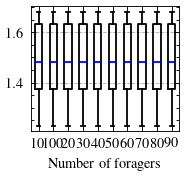

In [9]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')


display(df)
# Plot options
YY = 'SCOUT_DIST'
XX = 'CONTROLLER'
BP = 'Robots'
yl = 'Scouting efficiency'
fs = 0.66*hlwidth


# Process the data
df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharex=True, figsize=fs)

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Number of foragers")
# for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('')   

# bp[0].set_title('No Blockchain (Individualist)')
# bp[1].set_title('Blockchain (Individualist)')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/efficiency_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Total Value Collected (boxplot)

Dropdown(description='Experiment:', index=4, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '111_ep…

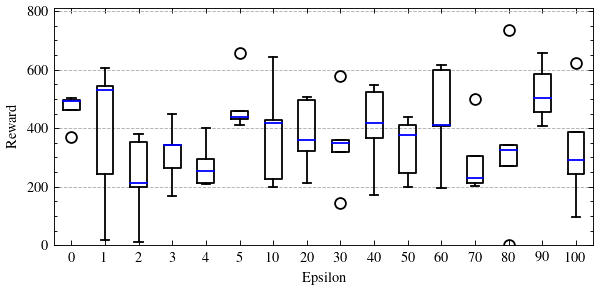

In [11]:
display(EXP_drop)
EXP  = EXP_drop.value
FILE = 'loop_function'

# Generate the dataframe
df = create_df(EXP, FILE)
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')

# Plot options
XX = 'CONTROLLER'
YY = 'VALUE'
BP = 'Robots'
yl = 'Reward'
fs = flwidth

# Process the data 
df["CONTROLLER"] = pd.to_numeric(df["CONTROLLER"])
df = df.groupby(['Robots', 'CONTROLLER', 'REP'], as_index=False).agg({YY:'max'})
# display(df)

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Epsilon")
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('') 
for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
# bp[0].set_title('Individualist (no blockchain)')
# bp[1].set_title('Individualist (blockchain)')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

SelectMultiple(description='Experiment:', index=(23, 24, 25), options=('/home/eksander/geth-argos/MarketForagi…

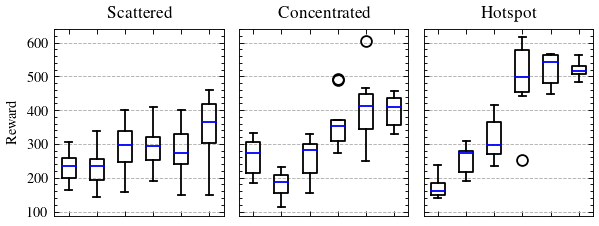

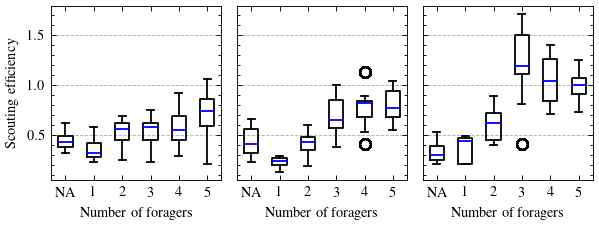

In [10]:
display(EXP_multiple)
EXP = EXP_multiple.value

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df2(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
YY = 'VALUE'
XX = 'Recruits'
BP = 'EXP'
yl = 'Reward'
titles = ['Scattered', 'Concentrated', 'Hotspot']
fs = fl22

# Process the data
df = df.groupby(['EXP', 'CFG','Recruits', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharey=True, figsize=fs, layout=[1,3])

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("")
for axi in bp: 
    labels = axi.get_xticklabels()
    labels[0] = 'NA'
    axi.set_xticklabels("")
    
bp[0].set_ylabel(yl)
i=0
for axi in bp: 
    axi.set_title(titles[i]) 
    i = i+1
plt.gcf().tight_layout()

plt.savefig("plots/multi/value.png", bbox_inches='tight', dpi=600)
plt.show()
#######################################################################################################

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df2(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0
# df = df[pd.to_numeric(df['REP']) >= 10]
# Plot options
YY = 'SCOUT_DIST'
XX = 'Recruits'
BP = 'EXP'
yl = 'Scouting efficiency'
fs = fl22

# Process the data
df = df.groupby(['EXP', 'CFG', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharey=True, figsize=fs, layout=[1,3])

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Number of foragers")
for axi in bp: 
    labels = axi.get_xticklabels()
    labels[0] = 'NA'
    axi.set_xticklabels(labels)
for axi in bp: axi.set_title('')  
    
bp[0].set_ylabel(yl)
plt.gcf().tight_layout()

plt.savefig("plots/multi/eff.png", bbox_inches='tight', dpi=600)
plt.show()


## Distance Travelled Ratio (boxplot)

Dropdown(description='Experiment:', index=1, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '130_st…

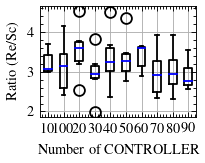

In [9]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'generic', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
XX = 'CONTROLLER'
BP = 'Robots'
fs = hlwidth
# df = df.query('Robots==20')

# Process the dataframe  
df['%DIST_RECRUIT'] = df['RECRUIT_DIST']/df['SCOUT_DIST']
df = df.groupby(['Robots','CONTROLLER', 'REP'], as_index=False).agg({'%DIST_RECRUIT':'mean'})

# Create plot
bp = df.groupby(BP).boxplot(column=['%DIST_RECRUIT'], by=XX, sharey=True, layout=(2,2))

# Edit plot 
plt.suptitle('')
for ax in bp: ax.set_xlabel("Number of %s" % XX)
for ax in bp: ax.set_ylabel("Ratio (Re/Sc)")
for ax in bp: ax.set_title('') 
# plt.gcf().tight_layout()

plt.savefig("plots/experiment_"+EXP+"/ratio_bp_%s.png" % XX, bbox_inches='tight', dpi=600)
plt.show()

## Ticks per second (histogram)

Dropdown(description='Experiment:', index=1, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '130_st…

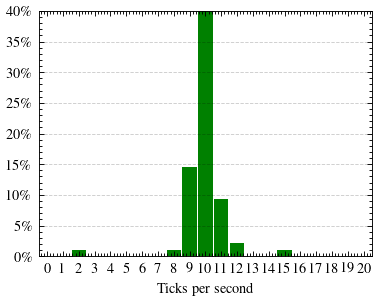

In [5]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'simulation')

# Process the dataframe 
df = df.get_param(df,'generic','tps')
bins = np.arange(df['tps'].min()-10, df['tps'].min()+12, 1)-0.5
xticks = np.arange(df['tps'].min()-10, df['tps'].min()+11, 1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPS'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0])*0.9, color='green')

# Edit plot
ax.grid(axis='y', linestyle='--', color='k', alpha=0.2, zorder=0) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 0.4)
ax.set_xticks(xticks)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Ticks per second')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/ticks_per_second.png", bbox_inches='tight')
plt.show()

## Smart Contract

In [31]:
# Select which experiment to plot the whole blockchain
display(EXP_drop, CFG_drop, REP_drop)

# Generate the dataframe
df = create_df(EXP_drop.value, 'sc')
df = df.query("CFG in @CFG_drop.value")
df = df.query("REP in @REP_drop.value")
df["XY"] = df["X"].astype(str) + df["Y"].astype(str)

# df = df[['TIME', 'BLOCK', 'HASH', 'MEANQ', 'WCOUNT', 'XY']]
#.sort_values('BLOCK').reset_index()


pd.options.display.max_rows = 10000
display(df)
# df[df['QLTY'] == 'yellow']

# # Plot options
# XX = 'BLOCK'
# YY = 'MEANQ'
# yl = 'Token Balance'
# fs = hlwidth

# # Process the data

# # Create plot
# ax = plt.axes()

# df.set_index([XX]).groupby(['ID','EXP','REP'])[YY].plot(ax=ax)

# # Edit plot 
# plt.suptitle('')
# ax.xaxis.grid(False)
# ax.yaxis.grid(True, linestyle = '--')

# ax.set_xlim(xmin=0, xmax=15)
# ax.set_ylabel(yl)
# ax.set_title('')   

# # Save plot
# plt.gcf().tight_layout()
# # plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

Dropdown(description='Exp:', index=5, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '111_epsilon',…

Dropdown(description='Cfg:', options=('egreedy_50',), value='egreedy_50')

Dropdown(description='Rep:', options=('001',), value='001')

,ID,TIME,BLOCK,HASH,PHASH,X,Y,QTTY,UTIL,QLTY,MEANQ,WCOUNT,EXP,CFG,REP,CONTROLLER,XY
0,1,88.048,39,0x15c965fa85a1eb20a12700a8acc010786c395993da3a...,0x007af6fdd8b8f948234246aa73fe50a65170b3f6b127...,43,62,15,8,yellow,0,0,113_epsilon_test,egreedy_50,001,50,4362
1,1,90.070,40,0xd299f7cb934b665aa1a2ed29ae5cee45515f42161c8e...,0x15c965fa85a1eb20a12700a8acc010786c395993da3a...,43,62,15,8,yellow,0,6,113_epsilon_test,egreedy_50,001,50,4362
2,1,93.834,41,0xe053344c964cfdab1e20c6064fcb91cab066e82fd892...,0xd299f7cb934b665aa1a2ed29ae5cee45515f42161c8e...,43,62,15,8,yellow,0,6,113_epsilon_test,egreedy_50,001,50,4362
3,1,95.064,42,0x4cd87cedb65a15c0e786c0300389c92895abe0a75ac8...,0xaea1ae03d520a8846e46e449207963df06cca59f8e74...,43,62,15,8,yellow,0,8,113_epsilon_test,egreedy_50,001,50,4362
4,1,96.491,43,0x9e41f902d0cfe48a1313d905cec38d23cd4b4e87b8d0...,0x4cd87cedb65a15c0e786c0300389c92895abe0a75ac8...,43,62,15,8,yellow,0,8,113_epsilon_test,egreedy_50,001,50,4362
5,1,99.129,44,0x84b16f081456a6493026d0bdfeb388cf9add6d011eac...,0x9e41f902d0cfe48a1313d905cec38d23cd4b4e87b8d0...,43,62,15,8,yellow,0,9,113_epsilon_test,egreedy_50,001,50,4362
6,1,100.451,45,0xfa2309dff530704ae740d0514752494b5156f6fbcaec...,0x84b16f081456a6493026d0bdfeb388cf9add6d011eac...,43,62,15,8,yellow,0,9,113_epsilon_test,egreedy_50,001,50,4362
7,1,102.502,46,0x99a1f87371e2c1a342197d8a3a4039c9768ec616d50d...,0xfa2309dff530704ae740d0514752494b5156f6fbcaec...,43,62,15,8,yellow,0,9,113_epsilon_test,egreedy_50,001,50,4362
8,1,104.429,47,0x08a607e6a1094210c0ca7c713925d1a344a806c3f8b8...,0x99a1f87371e2c1a342197d8a3a4039c9768ec616d50d...,43,62,15,8,yellow,0,9,113_epsilon_test,egreedy_50,001,50,4362
9,1,106.494,48,0xcdc51eb87fb6dc1d0c060504e9165084fe39e57480d6...,0x08a607e6a1094210c0ca7c713925d1a344a806c3f8b8...,43,62,15,8,yellow,0,9,113_epsilon_test,egreedy_50,001,50,4362


## Working Income VS Staking Income

Dropdown(description='Experiment:', options=('130_staking', 'eco', 'stake'), value='130_staking')

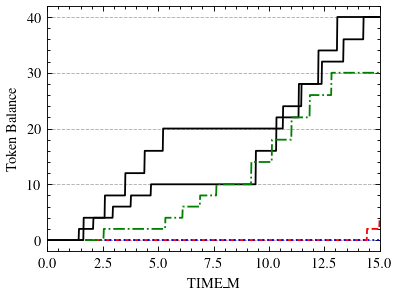

In [12]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'collection')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')


# REP = ['002']
# df = df.query("REP in @REP")

# Plot options
XX = 'TIME_M'
YY = [str(x) for x in range(1,int(df['Robots'].unique())+1)]
yl = 'Token Balance'
fs = hlwidth

# Process the data
df['SUM'] = df[YY].sum(axis=1)
df['TIME_M'] = df['TIME']/60

# Create plot
ax = plt.axes()
# fig,ax = plt.subplots(1,1,figsize=fs) 
# df.set_index([XX]).groupby(['ID','EXP','REP'])[YY].plot(ax=ax)
df.set_index([XX]).groupby(['REP'])['1'].plot(ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')

ax.set_xlim(xmin=0, xmax=15)
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
# plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Blockchain Visualizer

In [83]:
# Select which experiment to plot the whole blockchain
display(EXP_drop, CFG_drop, REP_drop)

Dropdown(description='Exp:', index=1, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '111_epsilon',…

Dropdown(description='Cfg:', index=3, options=('11_10', '11_100', '11_20', '11_30', '11_40', '11_50', '11_60',…

Dropdown(description='Rep:', index=2, options=('001', '002', '003', '004', '005', '006', '007', '008'), value=…

In [180]:
# Collect data
df = create_df(EXP, 'block')
df = df.query("CFG in @CFG")
df = df.query("REP in @REP")
df = df.drop_duplicates('HASH').sort_values('BLOCK').reset_index()

# Process data
genesis = df['PHASH'].iloc[0]
main_leaf = df[df['TDIFF'] == df['TDIFF'].max()]['HASH'].iloc[0]

# Iterate from main_leaf to genesis -> mainchain
df_mainchain = get_path_df(df, source=genesis, target=leading)

# Block hashes not in the mainchain -> forks
df_forks = df.query("HASH not in @df_mainchain['HASH']")

# Block hashes which are in forks, but are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')

# Block hashes which are in forks, are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')


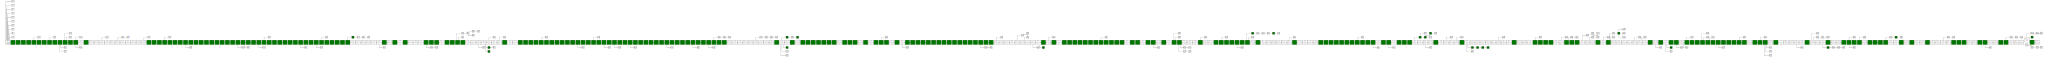

In [187]:
TRIM_FORKS = 3

# fork_paths = [[y] for y in df_leafs['HASH']]
# df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)
# fork_paths_longer_than = paths_longer_than(fork_paths, MIN_FORK_LENGTH)
# nodes_in_forks_longer_than = nodes_in_paths(fork_paths_longer_than)
# df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @df_mainchain['HASH']')

df_trimmed = trim_chain(df, 0)

bc = create_digraph(df)
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')

# Do something cool? Idk, for example try to keep all forks at same level (slow!)
df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

# Save plot
# bc_trimmed.render('plots/blockchain', format='pdf', view=True)
bc_trimmed